In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Sources

1. Bowers, Johnson, Pease, "Prospective hot-spotting: The future of crime mapping?", Brit. J. Criminol. (2004) 44 641--658.  [doi:10.1093/bjc/azh036](http://dx.doi.org/10.1093/bjc/azh036)

2. Bailey, Gatrell, "Interactive spatial data analysis", (Harlow : Longman Scientific & Technical, 1995.)  ISBN  	0582244935

3. Ratcliffe, "Aoristic analysis: the spatial interpretation of unspecific temporal events" [doi:10.1080/136588100424963](http://dx.doi.org/10.1080/136588100424963)

Source (1) discusses this family of algorithm, mostly to contrast it with their own.  Need to read (2).  (3) is mostly concerned with "Aoristic analysis", namely, how to deal with the fact that most crime occurs in a (possibly quite long) time window and not at a known exact time (e.g. when exactly did a burgulary occur, if the building was unattended for a time?)  However, section 4 discusses the classical algorithm.

# Algorithm

### Grid the space

Divide the area of interest into a grid. The grid is used for both the algorithm, and for data visualisation.  Smaller grids probably work better for this algorithm, and we could experiment with no grid at all.

### Aim of the algorithm

There is no direct consideration of time.  **Todo: Explain more here; don't just guess**  Instead a "sliding window" of time is used, and all events from, say, the last 8 weeks are used.  (This is addressed obliquely in (1) where they comment that as they only used 2 months' worth of data, they effectively used a window.)

Each event has a kernel drawn around it, and then these kernels are summed and sampled to produce an overall risk intensity.

### Traditional weights

For each grid cell, we use the location of the centre of the cell.  Then select a "bandwidth" $\tau$ (typically 200m, as claimed by (1), although we can find no actual value in (3)).  For each event $i$ let $d_i$ be the distance from the the cell to the event.  Then the weight is a quartic function

$$ \lambda = \sum_{d_i < \tau} \frac{3}{\pi \tau^2} \Big( 1 - \frac{d_i^2}{\tau^2} \Big)^2 $$

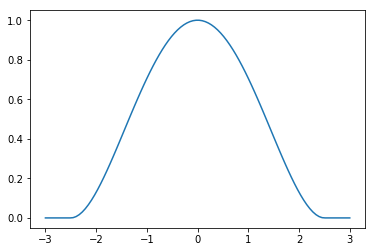

In [2]:
tau = 2.5
x = np.linspace(-3, 3, 100)
y = (1 - (abs(x) / tau) ** 2) ** 2
y = y * (abs(x) < tau)
_ = plt.plot(x,y)

As we can see, this is a (relatively) smooth function decaying to zero as the distance approaches the bandwidth.  The factor $3 / \pi\tau^2$ is just a (2 dimensional) normalisation factor.  If $\tau$ is fixed, as we only care about relative risk, this normalisation my be omitted.

As we use the centre of the cell for its location, and yet use the calculated risk for the whole cell, we introduce a certain bias.  This is discussed at length in (1), but I would view it more as a "sampling" issue.  The algorithm defines a kernel density estimation valid for any point, and then we sample this kernel at the centre of each cell.  As the cell size decreases, the sampling error should also decrease.

## Prediction

We can again look at the top 1%, 5%, 10% of cells by risk, and so forth.

## Implementation

We shall (**todo!!**) implement this algorithm both as a kernel density estimate, and as an optimised grid based algorithm.  (I wonder if it really makes much difference?)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp
import open_cp.retrohotspot as rhs

In [4]:
# Generate some random data
import datetime
size = 30
times = [datetime.datetime(2017,3,10) + datetime.timedelta(days=np.random.randint(0,10)) for _ in range(size)]
times.sort()
xc = np.random.random(size=size) * 500
yc = np.random.random(size=size) * 500
points = open_cp.TimedPoints.from_coords(times, xc, yc)

In [5]:
region = open_cp.RectangularRegion(0,500, 0,500)
predictor = rhs.RetroHotSpot()
predictor.data = points
predictor.weight = rhs.Quartic(100)
prediction = predictor.predict()

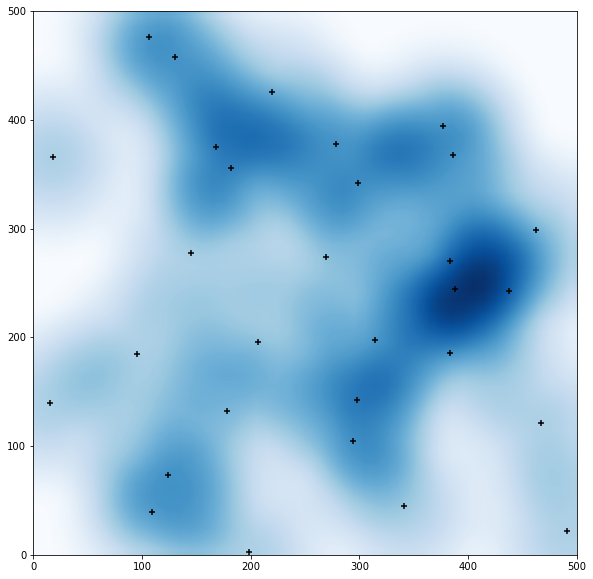

In [6]:
image_size = 50
density = np.empty((image_size, image_size))
for i in range(image_size):
    for j in range(image_size):
        density[j][i] = prediction.risk((i + 0.5) / image_size * 500, (j + 0.5) / image_size * 500)
        
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(density, cmap="Blues", extent=(0,500,0,500),origin="bottom", interpolation="bilinear")
ax.scatter(points.xcoords, points.ycoords, marker="+", color="black")
ax.set(xlim=[0, 500], ylim=[0, 500])
None

In [11]:
grid = open_cp.predictors.sample_region_to_grid(prediction.to_kernel(), 5, region)

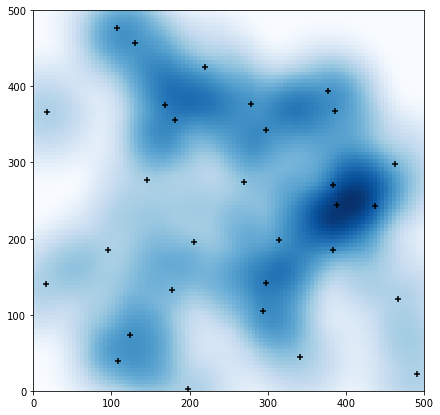

In [12]:
fig, ax = plt.subplots(figsize=(7,7))

ax.pcolormesh(*grid.mesh_data(), grid.intensity_matrix, cmap="Blues")
ax.scatter(points.xcoords, points.ycoords, marker="+", color="black")
ax.set(xlim=[0, 500], ylim=[0, 500])
None

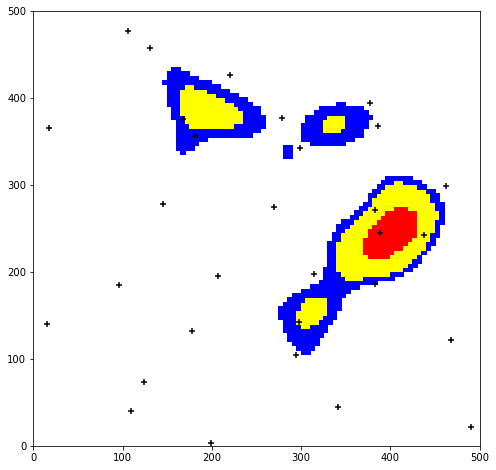

In [13]:
import matplotlib.colors

bins = np.array([0.9, 0.95, 0.99])
binned = np.digitize(grid.percentile_matrix(), bins)
masked = np.ma.masked_where(binned == 0, binned)

fixed_colour = matplotlib.colors.ListedColormap(["blue", "yellow", "red"])

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
ax.pcolormesh(*grid.mesh_data(), masked, cmap=fixed_colour)
ax.scatter(points.xcoords, points.ycoords, marker="+", color="black")
None